In [265]:
import numpy as np
import matplotlib.pyplot as plt

# Euler's method and Runge-Kutta (RK4)

Given the ODE:

$$\frac{dy}{dx} = f(x, y)$$

We can either come up with analytical solutions, which is a tedious and not always possible (or possible that we are aware of) process, or we can strive for approximate solutions, which falls under the domain of numerical analysis.

There are different methods/algorithms that one can utilize, but one of the easiest and more intuitive is that due to Euler (Euler's method). Runge-Kutta is a family of methods, really similar to Euler's method, but more optimized.
Here we'll discuss Euler's method, and the classical Runge-Kutta algorithm (RK4).

In [277]:
def apply_n(x, y, scheme, f, h, n):
    x_states = np.zeros(n)
    x_states[0] = x
    
    # In case y is not scalar, we create a corresponding multidimensional
    # array able to contain y
    y_states = np.zeros((n, *np.shape(y)))
    y_states[0] = y
    
    for i in range(1,n):
        x_states[i], y_states[i] = scheme(x_states[i-1], y_states[i-1],f, h)
        
    return x_states, y_states

def get_steps(x, other_x, h, round_f=np.floor):
    # While we are at it, we can make it go backwards:
    h = np.sign(other_x - x) * np.abs(h)
    n = int(round_f((other_x - x)/h))
    
    return n, h

def apply_range(x, y, scheme, f, other_x, h):
    n, h = get_steps(x, other_x, h)
    
    return apply_n(x, y, scheme, f, h, n)

def higher_degree(f, n):
    def f_wrapper(x, y):
        ytemp = np.zeros(*np.shape(y))
        
        for i in range(0,len(y)-1):
            ytemp[i] = y[i+1]
        
        ytemp[-1] = f(x,y)
        
        return ytemp
    
    return f_wrapper

# Some testing libraries:

def side_by_side(func, schemes, x, y, other_x, hs, exact = None, phase_space_plot=False, print_states=False):
    scheme_plots = len(schemes)
    num_plots = scheme_plots + (1 if exact else 0)
    
    func_name = func.__name__
    
    fig, axes = plt.subplots(num_plots, sharex=True, sharey=False)
    if num_plots == 1:
        axes = [axes]
    
    fig.suptitle(func_name)
    
    for i, scheme in enumerate(schemes):
        scheme_name = scheme.__name__
        
        ax = axes[i]
        ax.set_title(scheme_name)
        
        for (i, (n, h)) in enumerate(map(lambda h: get_steps(x, other_x, h), hs)):
            x_states, y_states = func(scheme, x, y, h, n)
            #print(scheme, x, y, h, n)
            
            if print_states:
                print(f"Tables for {scheme_name}, h={h}, n={n}")
                for el in zip(x_states4, y_states4):
                    print(el[0], " : ", el[1])
                    
            if phase_space_plot:
                # Phase space plot only works when a y state has at least two elements:
                ax.plot(y_states[:,0], y_states[:,1],  f"C{i}", label=f"h = {h}")
            else:
                #print(id(x_states), len(x_states), id(y_states), len(y_states))
                ax.plot(x_states, y_states, f"C{i}", label=f"h = {h}")
        
        if exact is not None:
            ax = axes[-1]
            
            # Not meant to be used with phase_space_plot
            if phase_space_plot:
                raise Exception("phase_space_plot cannot be used with exact")
            
            linspace = np.linspace(x, other_x)
            results = exact(linspace)
            
            ax.set_title("Exact solution")
            ax.plot(x_states, y_state)
            
        
        ax.legend()
    
    #return fig

## Euler's method

This is an iterative approach, where, we reasonably assume that we can approximate the derivative in a discrete (non-continuos) way. By choosing the step difference of the parameter, based on an initial state, we can calculate the subsequent states of the system:

$$x_{n+1} = x_n + h$$
$$y_{n+1} = y_n + hf(x_n, y_n)$$

In [262]:
def euler_step(x, y, f, h):
    x_next = x + h
    #print(y, np.multiply(h, f(x,y)))
    #y_next = y + h * f(x, y)
    y_next = y + np.multiply(h, f(x,y))
    
    return x_next, y_next

In order to solve an ODE of a higher degree of the form
$$\frac{d^ny}{{dx}^n} = f(x,y,y',y'',\dots,y^{(n-1)})$$
, we can let $y$ be a vector, where $y_i = f^{(i)}(x)$, for $0\leq i \leq n-1$

Then, we have:
$$y' = \begin{pmatrix} f'(x) \\ f''(x) \\ \ldots \\ f^{(n)}(x) \end{pmatrix} = \begin{pmatrix} y_1 \\ y_2 \\ \ldots \\ f(x, y_0, y_1, \ldots, y_{n-2}) \end{pmatrix} $$

So ${y'}_{n-1} = f(x,y_0, y_1, \ldots, y_{n-2})$ and ${y'}_i = y_{i+1}$ for $0 \leq i \leq n-2$. This is implemented in higher_degree(f, n).

## Runge-Kutta method

Runge-Kutta methods are a family of methods rather similar to Euler's method, but with the slight difference that the step difference is calculated as weighted sum of the function evaluated for different points. The number of such evaluations (which are recurrent in nature, each one depends on the one calculated beforehand, the first evaulation being the standard one utilized in Euler's method) depends. For RK4 we have:

$$x_{n+1} = x_n + h$$
$$y_{n+1} = y_n + \frac{1}{6}h(k_1 + 2k_2 + 2k_3 + k_4)$$

$$k_1 = f(t_n, y_n)$$
$$k_2 = f(t_n + \frac{h}{2}, y_n + h\frac{k_1}{2})$$
$$k_3 = f(t_n + \frac{h}{2}, y_n + h\frac{k_2}{2})$$
$$k_4 = f(t_n + h, y_n + hk_3)$$

In [323]:
def rk4_step(x, y, f, h):
    x_next = x + h
    
    # Simple '*' operator seems to not work in some cases
    # so we use an aliased np.multiply
    m = lambda x, y: np.multiply(x, y)
    
    k1 = f(x,y)
    k2 = f(x + h/2, y + m(h,k1)/2)
    k3 = f(x + h/2, y + m(h,k2)/2)
    k4 = f(x + h, y + m(h, k3))
    
    y_next = y + np.multiply(h, k1 + 2*k2 + 2*k3 + k4)/6
    
    return x_next, y_next

## Some examples:

## Side by side

In [306]:
# 0.5 seems problematic
hs = [0.5, 0.2, 0.05, 0.01, 0.001]

### Oscillations:

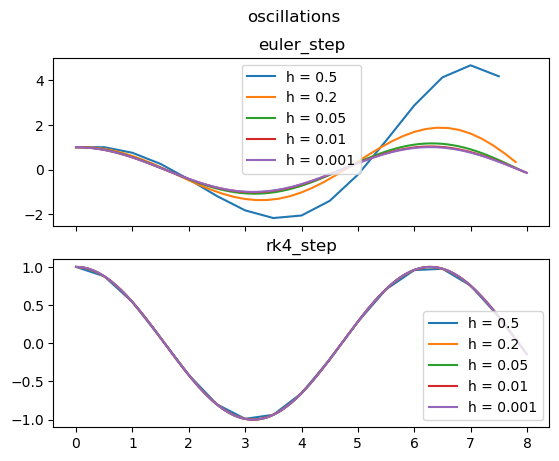

In [307]:
# Oscillations:

def oscillations(scheme, x, y, h, n):
    # y'' + omega**2*y = 0
    # y'' = -omgea**2*y
    
    omega = -1 #If other than this, Euler's method just explodes and makes it hard to see anything
    omegas = omega**2
    
    f = higher_degree(lambda x, y: -1*omegas*y[0], 2)

    x_states, y_states = apply_n(x, y, scheme, f, h, n)
    
    return x_states, y_states[:,0]

side_by_side(oscillations, [euler_step, rk4_step], 0, np.array([1, 0]), 8, hs)

### Damped oscillations

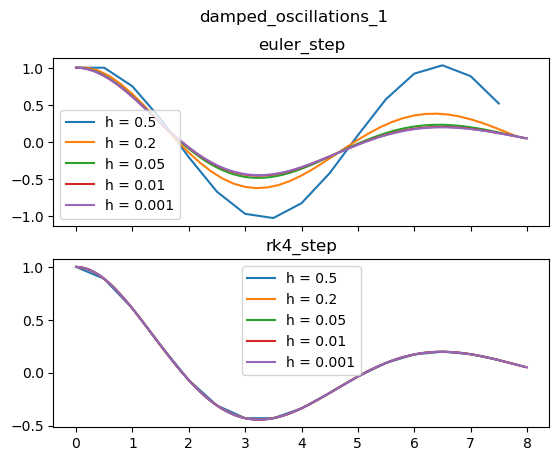

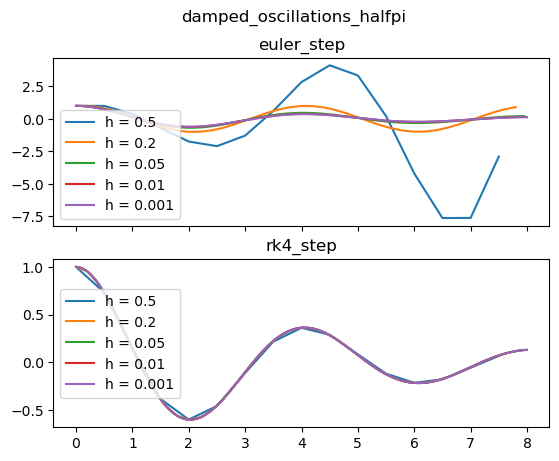

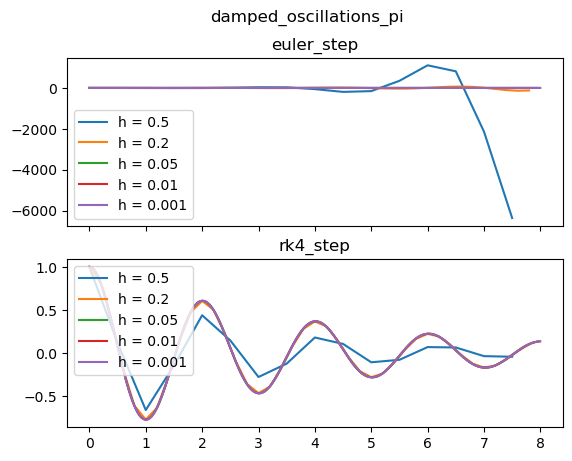

In [308]:
# Damped oscillations:

def damped_oscillations(scheme, x, y, h, n, omega):
    # y'' + cy' + omega**2*y = 0
    # y'' = -cy' -omega**2*y
    
    omegas = omega**2
    
    c = 0.5
    f = higher_degree(lambda x, y: -1 * omegas * y[0] - c * y[1], 2)

    x_states, y_states = apply_n(x, y, scheme, f, h, n)
    
    return x_states, y_states[:,0]

def damped_oscillations_1(*args):
    return damped_oscillations(*args, 1)

def damped_oscillations_halfpi(*args):
    return damped_oscillations(*args, np.pi/2)

def damped_oscillations_pi(*args):
    return damped_oscillations(*args, np.pi)

side_by_side(damped_oscillations_1, [euler_step, rk4_step], 0, np.array([1, 0]), 8, hs)
side_by_side(damped_oscillations_halfpi, [euler_step, rk4_step], 0, np.array([1, 0]), 8, hs)
side_by_side(damped_oscillations_pi, [euler_step, rk4_step], 0, np.array([1, 0]), 8, hs)

## Interesting:

### Predator/Prey phase space with RK4

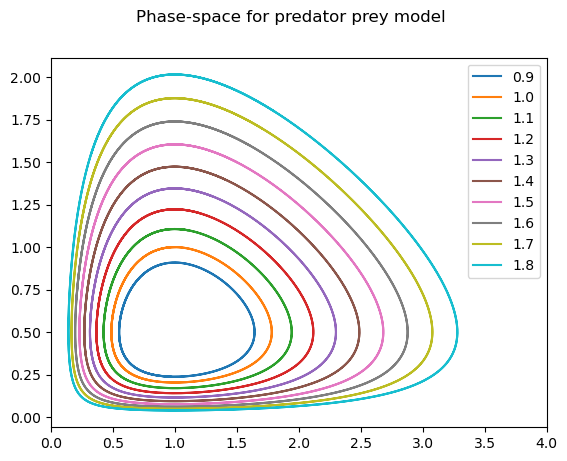

In [372]:
def predator_prey(scheme, x, y, h, n):
    # Lotka-Volterra equations
    # y[0]' = α*y[0] - β*y[0]*y[1]
    # y[1]' = δ*y[0]*y[1] - γ*y[1]
    
    α = 2.0/3
    β = 4.0/3
    γ = 1
    δ = 1
    
    omegas = omega**2
    
    f = lambda x, y: np.array([
        α*y[0] - β*y[0]*y[1],
        δ*y[0]*y[1] - γ*y[1]
    ])

    x_states, y_states = apply_n(x, y, scheme, f, h, n)
    
    return x_states, y_states


plt.xlim(0, 4)
plt.suptitle("Phase-space for predator prey model")

for i, val in enumerate(np.linspace(0.9, 1.8, 10)):
    pp_x, pp_y = predator_prey(rk4_step, 0, np.array([val, val]), 0.01, 2000)
    plt.plot(pp_y[:,0], pp_y[:,1], f"C{i}", label=f"{np.round(val,2)}")

plt.legend();

### Lorenz attactor:

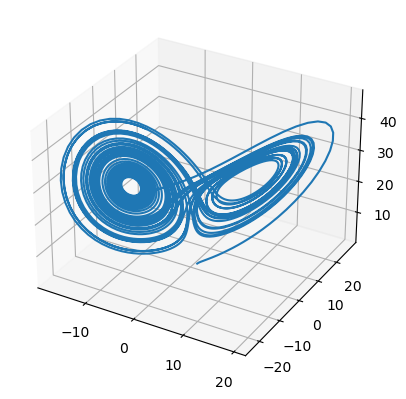

In [383]:
# The example values come from Wikipedia
def lorenz_attractor(scheme):
    # x is s[0], y is s[1] and z is s[2]:
    
    # x' = σ(y-x)
    # y' = x(ρ-z) - y
    # z' = xy - βz
    
    σ = 10.0
    ρ = 28.0
    β = 8.0/3.0
    
    f = lambda t, s: np.array([
        σ*(s[1]-s[0]),
        s[0]*(ρ-s[2]) - s[1],
        s[0]*s[1] - β*s[2]
    ])
    
    # From t=0 to t=40, with a step size of 0.01, for 4000 steps
    
    state0 = [1.0, 1.0, 1.0]
    
    t_states, states = apply_range(0, state0, scheme, f, 40, 0.01)
    
    return t_states, states

lorenz_time, lorenz_states = lorenz_attractor(rk4_step)

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot(lorenz_states[:,0], lorenz_states[:,1], lorenz_states[:,2]);
    

## Others, not as interesting

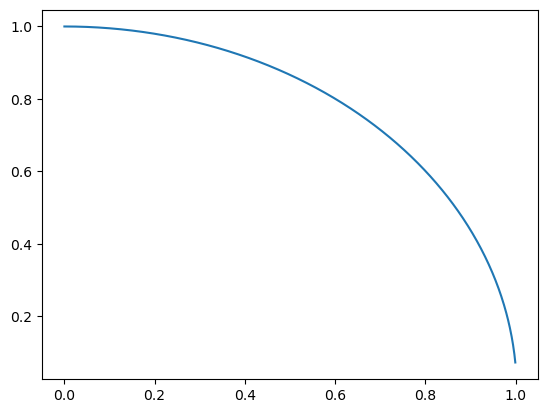

In [385]:
# A circle, kind of:

x_states, y_states = apply_n(0, 1, euler_step, lambda x, y: -x/y, 0.001, 1000)
plt.plot(x_states, y_states);

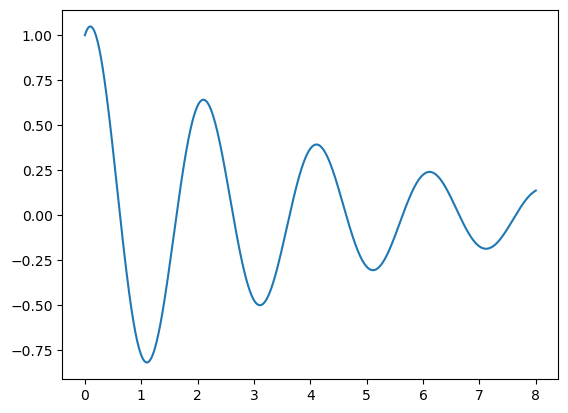

In [386]:
# Damped oscillations

# y'' + cy' + omega**2*y = 0
# y'' = -cy' -omega**2*y
omega1 = np.pi
c1 = 0.5

x_initial1 = 0
y_initial1 = np.array([1, 1])

f1 = higher_degree(lambda x, y: -1 * omega**2 * y[0] - c1 * y[1], 2)

x_states1, y_states1 = apply_n(x_initial1, y_initial1, euler_step, f1, 0.001, 8000)
plt.plot(x_states1, y_states1[:,0]);

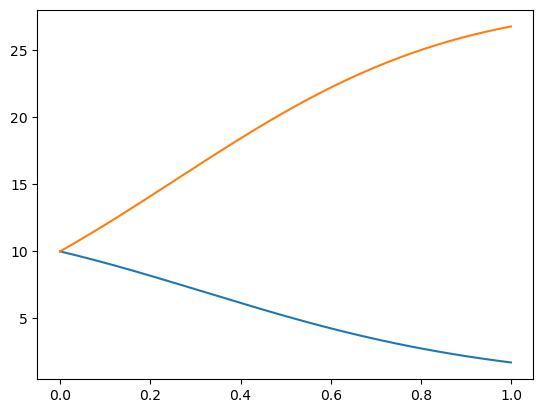

In [387]:
# Foxes and rabbits

#nr = 10
#br = 0.2
#dr = 0.1

#nf = 10
#bf = 0.2
#df = 0.1

nr = 10
br = 0.2
dr = 0.1

nf = 10
bf = 0.2
df = 0.1

# y = [n_rabbits, n_foxes]
# y' = [(br - dr*y[1])*y[0], (bf*y[0] - df)*y[1]]

x_initial2 = 0
y_initial2 = np.array([nr, nf])

f2 = lambda x, y: [(br - dr*y[1])*y[0], (bf*y[0] - df)*y[1]]
x_states2, y_states2 = apply_n(x_initial2, y_initial2, euler_step, f2, 0.001, 1000)
plt.plot(x_states2, y_states2);

[[1.         1.        ]
 [1.1        1.1       ]
 [1.2111     1.221     ]
 [1.3380444  1.36887531]
 [1.48697433 1.5520369 ]
 [1.66596961 1.78282081]
 [1.88590093 2.07983334]
 [2.1617767  2.4720693 ]
 [2.51491069 3.00647548]
 [2.97651252 3.76257721]]


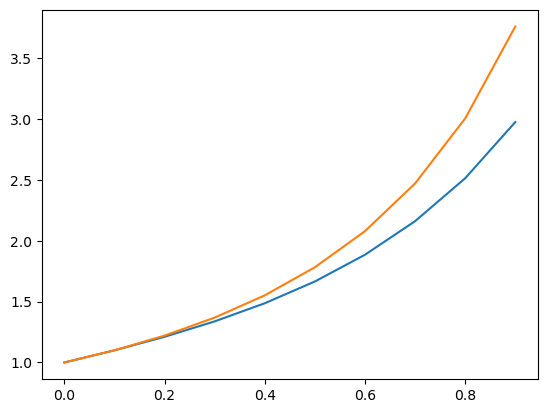

In [388]:
x_initial3 = 0
y_initial3 = np.array([1, 1])

f3 = lambda x, y: [x**2 * y[0] + y[1], y[0]*y[1]]
x_states3, y_states3 = apply_n(x_initial3, y_initial3, euler_step, f3, 0.1, 10)

print(y_states3)
plt.plot(x_states3, y_states3);

0.0  :  [1. 0.]
0.1  :  [ 1.  -0.1]
0.2  :  [ 0.99 -0.2 ]
0.30000000000000004  :  [ 0.97  -0.299]
0.4  :  [ 0.9401 -0.396 ]
0.5  :  [ 0.9005  -0.49001]
0.6  :  [ 0.851499 -0.58006 ]
0.7  :  [ 0.793493  -0.6652099]
0.7999999999999999  :  [ 0.72697201 -0.7445592 ]
0.8999999999999999  :  [ 0.65251609 -0.8172564 ]
0.9999999999999999  :  [ 0.57079045 -0.88250801]
1.0999999999999999  :  [ 0.48253965 -0.93958705]
1.2  :  [ 0.38858094 -0.98784102]
1.3  :  [ 0.28979684 -1.02669911]
1.4000000000000001  :  [ 0.18712693 -1.0556788 ]
1.5000000000000002  :  [ 0.08155905 -1.07439149]
1.6000000000000003  :  [-0.0258801 -1.0825474]
1.7000000000000004  :  [-0.13413484 -1.07995939]
1.8000000000000005  :  [-0.24213078 -1.0665459 ]
1.9000000000000006  :  [-0.34878537 -1.04233282]
2.0000000000000004  :  [-0.45301865 -1.00745429]
2.1000000000000005  :  [-0.55376408 -0.96215242]
2.2000000000000006  :  [-0.64997932 -0.90677602]
2.3000000000000007  :  [-0.74065692 -0.84177808]
2.400000000000001  :  [-0.82483473

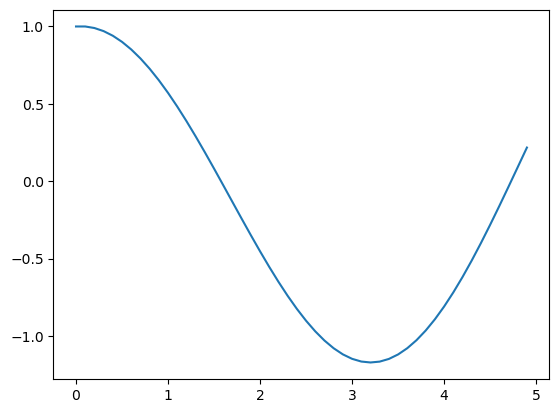

In [271]:
# Oscillations:

# y'' + chi*y = 0
# y'' = -chi*y
chi = np.pi

x_initial4 = 0
y_initial4 = np.array([1, 0])

f4 = higher_degree(lambda x, y: -1 * y[0], 2)

x_states4, y_states4 = apply_n(x_initial4, y_initial4, euler_step, f4, 0.1, 50)
plt.plot(x_states4, y_states4[:,0])
for el in list(zip(x_states4, y_states4)):
    print(el[0], " : ", el[1])

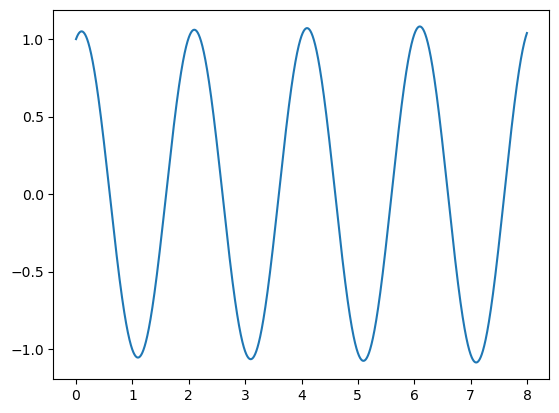

In [389]:
# Oscillations:

# y'' + omega**2*y = 0
# y'' = -omega**2*y
omega = np.pi

x_initial0 = 0
y_initial0 = np.array([1, 1])

f0 = higher_degree(lambda x, y: -1 * omega**2 * y[0], 2)

x_states0, y_states0 = apply_n(x_initial0, y_initial0, euler_step, f0, 0.001, 8000)
plt.plot(x_states0, y_states0[:,0]);